# Installations

In [11]:
!pwd

#mounting drive
from google.colab import drive
drive.mount('/content/drive')

!ls

# java install
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!ls /usr/lib/jvm/

# spark download & extract
!wget -q https://downloads.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz

!tar -xvzf spark-3.4.0-bin-hadoop3.tgz

#install findspark
!pip install -q findspark

#install pyspark
!pip install pyspark

# install constraction
!pip install contractions

!pip install wordcloud

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive	     spark-3.4.0-bin-hadoop3	  spark-3.4.0-bin-hadoop3.tgz.1
sample_data  spark-3.4.0-bin-hadoop3.tgz
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lis

In [12]:
# initialize the environment for Apache Spark
import findspark
findspark.init()

#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3.tgz"



In [13]:
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import contractions
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler


# Loading Data

In [17]:
#creating SparkSession

spark = SparkSession.builder \
        .master("local") \
        .appName("Hands-on PySpark on Google Colab") \
        .config("spark.sql.execution.arrow.enabled", "true") \
        .getOrCreate()

In [22]:

spark_data = spark.read.format('csv').options(header='true').load('/content/drive/MyDrive/ecommerce project/One&only1.csv')


In [23]:
spark_data.show(5,truncate=False)

+--------------------+--------+-------------------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                  |Category|name                     |reviews_rating|reviews_text                                                                                                                                                                                                                                     

# Preprocessing

In [24]:
spark_data.printSchema()

root
 |-- id: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- name: string (nullable = true)
 |-- reviews_rating: string (nullable = true)
 |-- reviews_text: string (nullable = true)



In [25]:
spark_data.count()

spark_data.describe()

DataFrame[summary: string, id: string, Category: string, name: string, reviews_rating: string, reviews_text: string]

In [26]:
null_sum = spark_data.agg(*[spark_sum(col(c).isNull().cast("int")).alias(c) for c in spark_data.columns])

In [28]:
spark_data.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|                  id|            Category|                name|      reviews_rating|        reviews_text|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|               28054|               27967|               27939|               27764|               27751|
|   mean|                null|                null|                null|    4.56234454417649|                null|
| stddev|                null|                null|                null|  0.7449765704460651|                null|
|    min|",3,"So I was exc...| I can recommend ...| Amazon Tap Porta...| Alexa can't hear...| and find out the...|
|    max|AVzvXXxbvKc47QAVfRhy|sometimes the pag...|love the feel of ...|with excellent co...|İt is cheap table...|
+-------+--------------------+--------------------+--------------------+--------

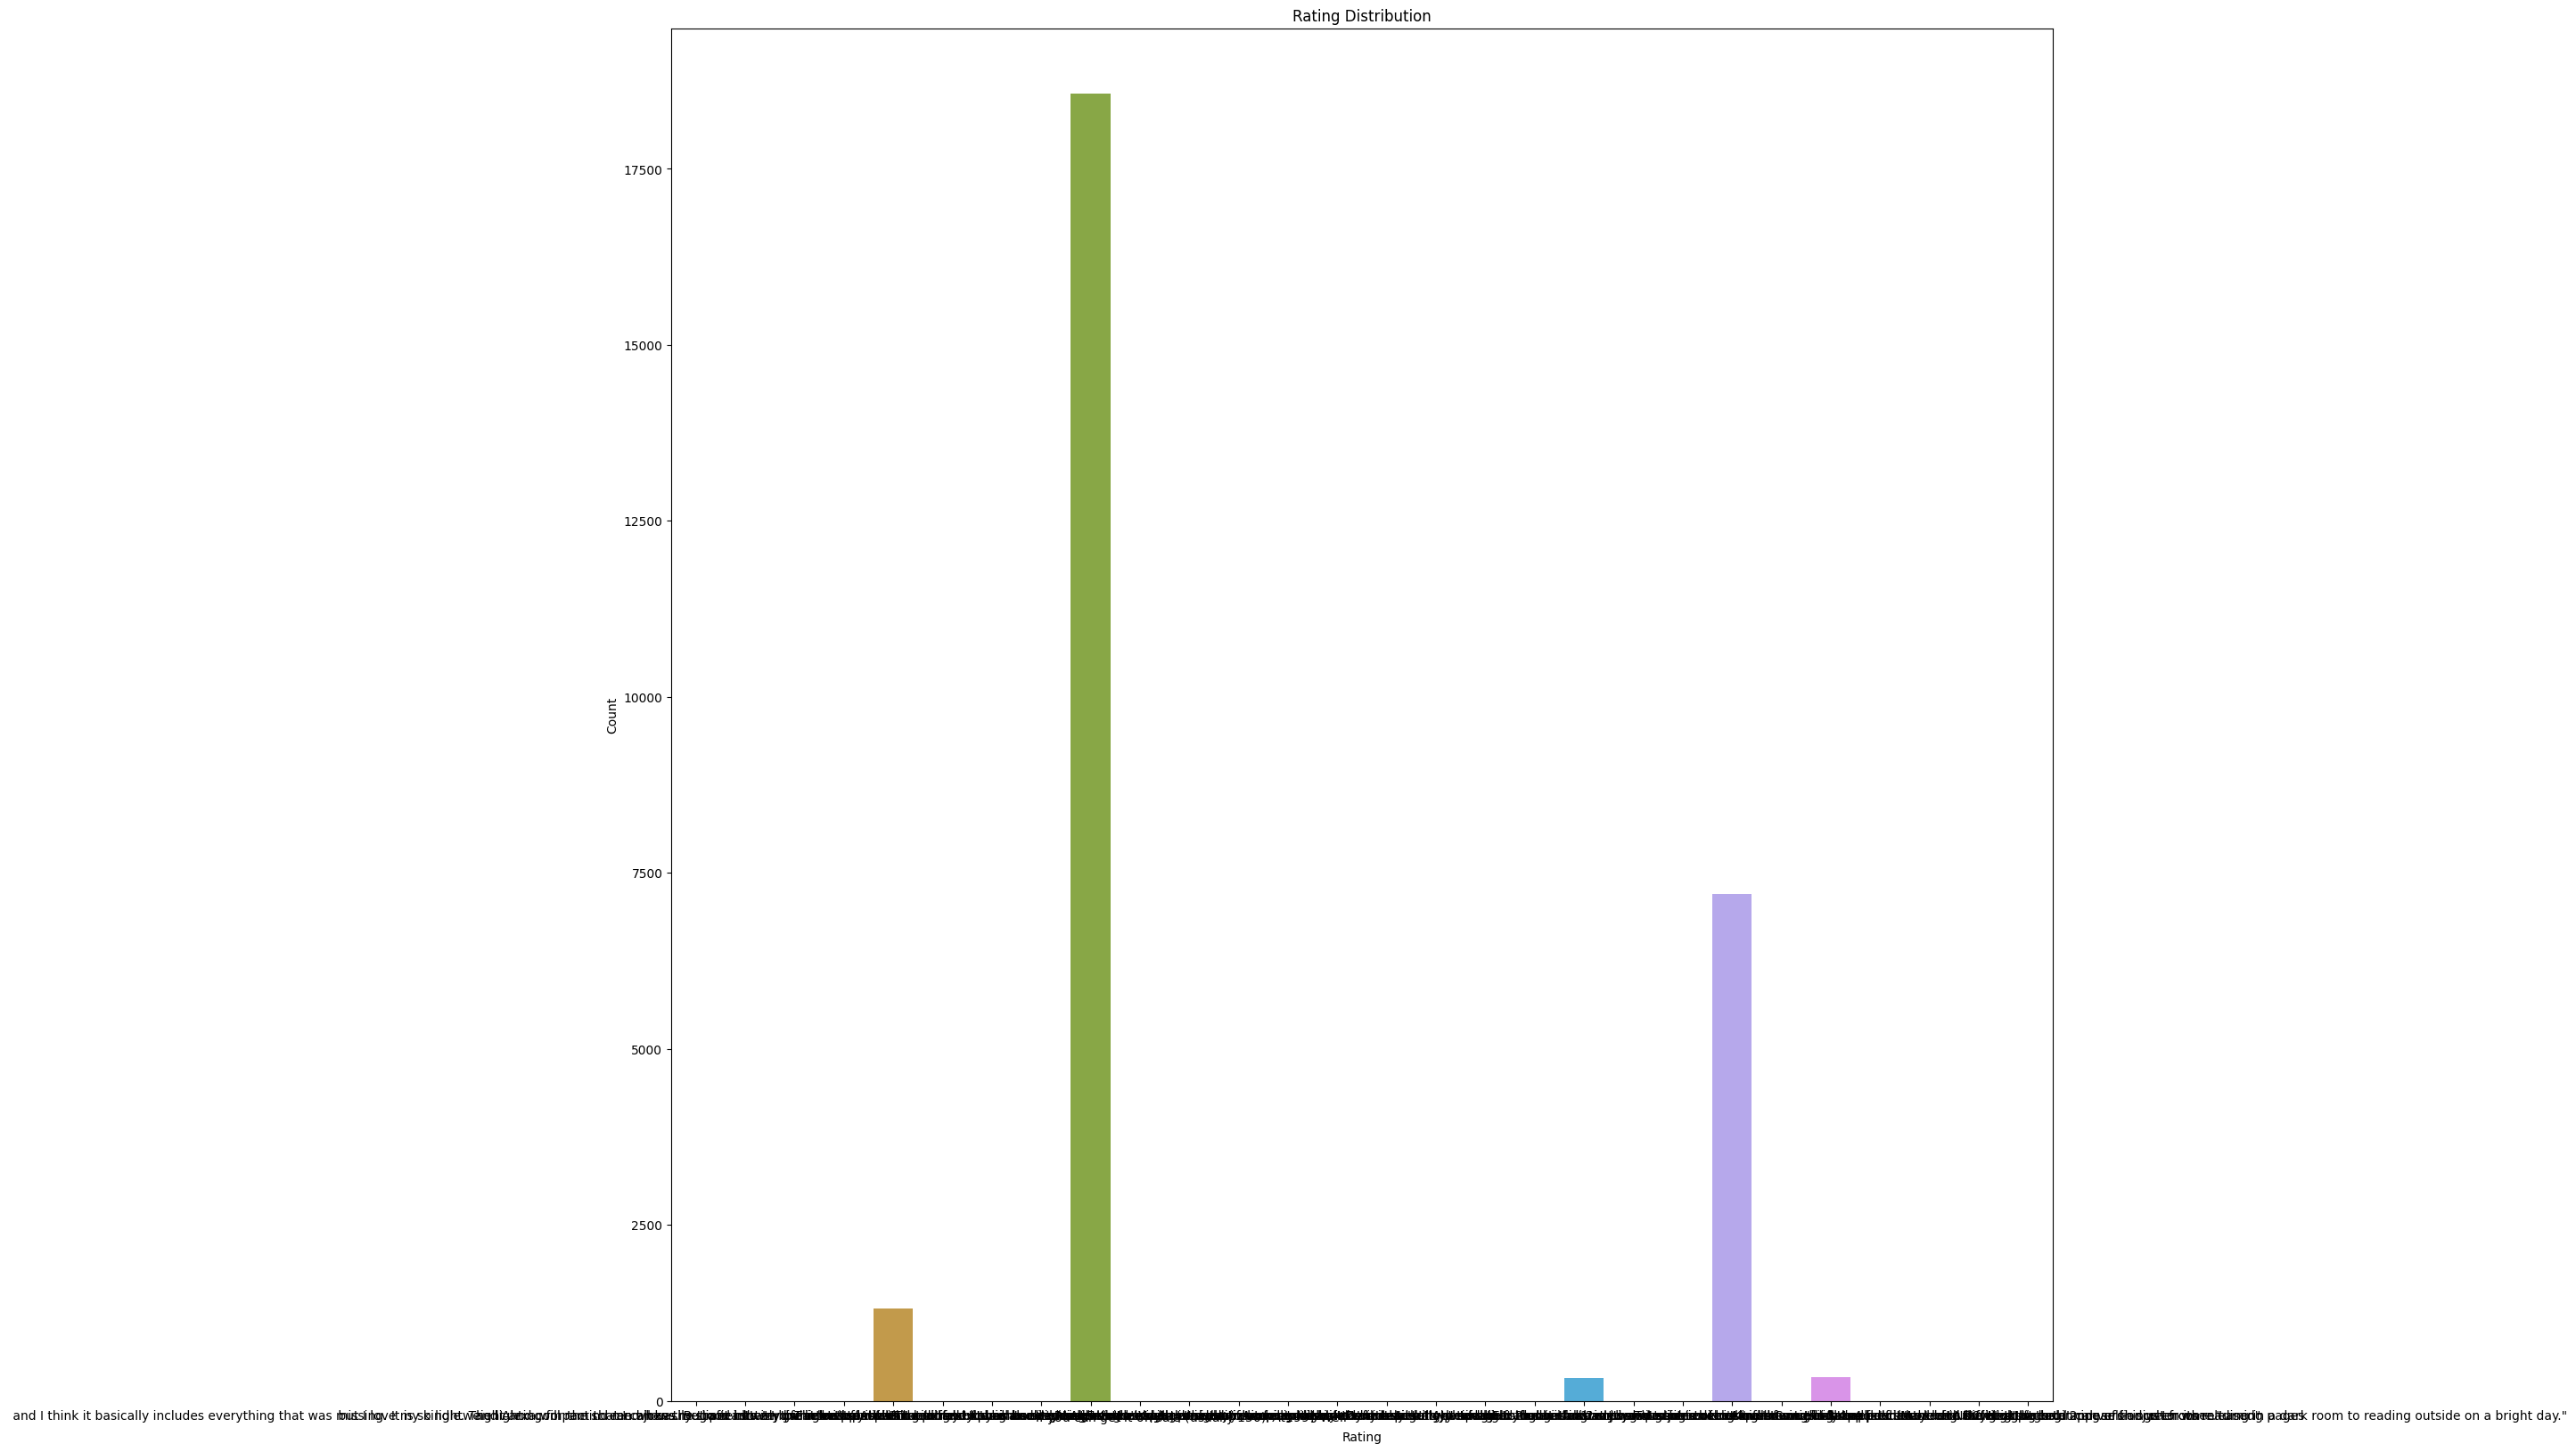

In [29]:
# ratings count
rating_counts = spark_data.groupBy("reviews_rating").count()
rating_counts_pd = rating_counts.toPandas()

# Bar plot of rating counts
plt.figure(figsize=(20, 20))
sns.barplot(x='reviews_rating', y='count', data=rating_counts_pd)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

In [31]:
# Download necessary resources for NLTK
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
tokenizer = Tokenizer(inputCol='reviews_text', outputCol='tokenized_text')
spark_data = tokenizer.transform(spark_data)

stop_remove = StopWordsRemover(inputCol='tokenized_text', outputCol='token_stop')
spark_data = stop_remove.transform(spark_data)

In [37]:
# Define the Lemmatizer
lemmatizer = WordNetLemmatizer()

def cleaner(text):
    new_text = re.sub(r"'s\b", " is", text)
    new_text = re.sub("#", "", new_text)
    new_text = re.sub("@[A-Za-z0-9]+", "", new_text)
    new_text = re.sub(r"http\S+", "", new_text)
    new_text = contractions.fix(new_text)
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
    new_text = new_text.lower().strip()

    cleaned_text = ''
    for token in new_text.split():
        cleaned_text = cleaned_text + lemmatizer.lemmatize(token) + ' '

    return cleaned_text

In [38]:
# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # cleaner function
        cleaned_text = cleaner(text)

        # Tokenization
        tokens = word_tokenize(cleaned_text)

        # Remove punctuation
        tokens = [token for token in tokens if token not in string.punctuation]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Reconstruct preprocessed text
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text
    else:
        # If the input is not a string, return an empty string
        return ''

In [39]:
# Define the UDF for preprocessing text
preprocess_text_udf = udf(preprocess_text, StringType())

# Apply the UDF to 'reviews_text' column and create a new column 'cleaned_reviews'
spark_data = spark_data.withColumn('cleaned_reviews', preprocess_text_udf(spark_data['reviews_text']))

# Sentiment Analysis

In [ ]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a UDF for sentiment analysis
def analyze_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores["compound"]

analyze_sentiment_udf = udf(analyze_sentiment, StringType())

In [ ]:
# Function to classify sentiment
def classify_sentiment(score):
    if score['compound'] > 0.6:
        return 'positive'
    elif score['compound'] < 0.1:
        return 'negative'
    else:
        return 'neutral'

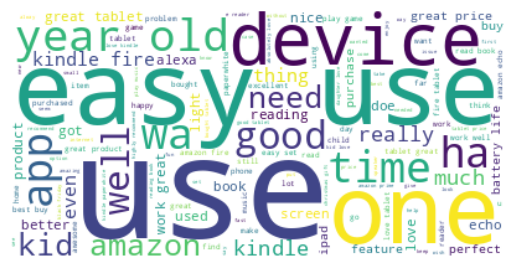

In [42]:
# Import the necessary libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Preprocess the text data
preprocessed_text = spark_data.select('cleaned_reviews').rdd.flatMap(lambda x: x).collect()
text = ' '.join(preprocessed_text)

# Generate the word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Web-App Testing

In [44]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 17.2 MB/s eta 0:00:00


In [45]:
pip install --upgrade streamlit

In [46]:
%%writefile app.py

import webbrowser


from nltk.sentiment.vader import SentimentIntensityAnalyzer
import streamlit as st
import pandas as pd
import re
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import webbrowser

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Define the Lemmatizer
lemmatizer = WordNetLemmatizer()

def cleaner(text):
    """
    Clean and preprocess a given text using various steps.

    This function applies a series of cleaning operations to the input text, including replacing contractions,
    removing hashtags and Twitter handles, eliminating URLs, converting to lowercase, and lemmatizing words.

    Args:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned and preprocessed text.
    """
    new_text = re.sub(r"'s\b", " is", text)
    new_text = re.sub("#", "", new_text)
    new_text = re.sub("@[A-Za-z0-9]+", "", new_text)
    new_text = re.sub(r"http\S+", "", new_text)
    new_text = contractions.fix(new_text)
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
    new_text = new_text.lower().strip()

    cleaned_text = ''
    for token in new_text.split():
        cleaned_text = cleaned_text + lemmatizer.lemmatize(token) + ' '

    return cleaned_text

def preprocess_text(text):
    """
    Preprocess a given text for further analysis.

    This function takes the input text, applies the 'cleaner' function, tokenizes the cleaned text,
    removes punctuation and stopwords, and then reconstructs the preprocessed text.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text ready for analysis.
    """
    if isinstance(text, str):
        # Apply the 'cleaner' function
        cleaned_text = cleaner(text)

        # Tokenization
        tokens = word_tokenize(cleaned_text)

        # Remove punctuation
        tokens = [token for token in tokens if token not in string.punctuation]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Reconstruct preprocessed text
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text
    else:
        # If the input is not a string, return an empty string
        return ''

# Streamlit app header
st.header('Sentiment Analysis')

# Text input for sentiment analysis
text_input = st.text_input('Enter text for sentiment analysis:')

if text_input:
    # Calculate sentiment scores
    sentiment_scores = sid.polarity_scores(text_input)
    polarity = sentiment_scores['compound']

    # Classify sentiment
    if polarity > 0.6:
        sentiment = 'Positive'
        sentiment_text = 'This text is positive!'
    elif polarity < 0.1:
        sentiment = 'Negative'
        sentiment_text = 'This text is negative.'
    else:
        sentiment = 'Neutral'
        sentiment_text = 'This text is neutral.'

    # Display sentiment scores, classification, and associated text
    st.write('Sentiment Scores:', sentiment_scores)
    st.write('Sentiment:', sentiment)
    st.write('Sentiment Text:', sentiment_text)

# Text input for text cleaning
clean_input = st.text_input('Enter text to clean:')

if clean_input:
    # Clean and preprocess text
    cleaned_text = cleaner(clean_input)
    preprocessed_text = preprocess_text(cleaned_text)

    # Display cleaned and preprocessed text
    st.write('Cleaned Text:', cleaned_text)
    st.write('Preprocessed Text:', preprocessed_text)

with st.expander('Analyze CSV'):
    upl = st.file_uploader('Upload file')

    if upl:
        df = pd.read_csv(upl)

        # ... (your score and analyze functions)

        df['score'] = df['reviews.text'].apply(score)
        df['analysis'] = df['score'].apply(analyze)
        st.write(df.head(10))

        @st.cache
        def convert_df(df):
            return df.to_csv(index=False).encode('utf-8')

        csv = convert_df(df)

        st.download_button(
            label="Download data as CSV",
            data=csv,
            file_name='sentiment.csv',
            mime='text/csv'
        )

# Streamlit app header
st.header('Open tableau')

# URL to open
link_url = "https://public.tableau.com/views/updatedproject_16930187945980/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link"


st.markdown(f'[Click here to open]({link_url})')

Overwriting app.py


In [48]:
#Test code
#gives ip address

!curl ipecho.net/plain

#Gives ip addresses with port numbers
#!sudo lsof -i -P -n | grep LISTEN

35.227.186.137

In [49]:
!streamlit run app.py & npx localtunnel --port 8501



npx: installed 22 in 6.236s
your url is: https://solid-vans-punch.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.227.186.137:8501

  Stopping...
^C
